## Project2 Submission

Please fill out:
* Student name: Wonuola Abimbola, Kibae Kim
* Student pace: full time
* Scheduled project review date/time: 4.23 / 10:30
* Instructor name: Fangfang

## Overview

For this project, we will be using regression modeling to analyze house sales price in the King County area between 2014 and 2015.

## Business Problem

1. Do the prices of the houses sold differ depending on the city they're located in?
2. Does renovation have an effect on house price?
3. Do waterfront houses have higher prices than other houses?

## Data Understanding

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from pyproj import CRS
from shapely.geometry import Point, Polygon

%matplotlib inline

### Houses and Cities Databases

We used data of King County house sales price and house information, incorporated areas of King County / city area from King County GIS Open Data, and zipcode information from Zip Codes To Go.

In [2]:
#loading the data as a pandas dataframe
df = pd.read_csv('data/kc_house_data.csv') 

In [3]:
# loading the shape file as geopandas dataframe
gdf = gpd.read_file("data/mapping/Incorporated_Areas_of_King_County___city_area.shp")

gdf

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2..."
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5..."
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2..."
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3..."
...,...,...,...,...,...,...
57,58,SN,Snoqualmie,114919.649620,2.009551e+08,"POLYGON ((-121.82845 47.54868, -121.82841 47.5..."
58,59,ST,SeaTac,101640.458450,2.866419e+08,"POLYGON ((-122.30332 47.48876, -122.30305 47.4..."
59,60,TU,Tukwila,125946.874691,2.683084e+08,"POLYGON ((-122.29128 47.51595, -122.29134 47.5..."
60,61,WO,Woodinville,89621.634641,1.577113e+08,"POLYGON ((-122.11284 47.76882, -122.11284 47.7..."


In [4]:
# reading in file to get the cities that correspond to the zipcodes
payload=pd.read_html("https://www.zipcodestogo.com/Washington/")
df_zipcode = payload[1]
df_zipcode = df_zipcode.drop([0,1], axis=0)
df_zipcode = df_zipcode.drop([3], axis=1)
df_zipcode.columns = ['zipcode', 'city', 'county']
df_zipcode.index -= 2

zipcode_dic = {}
for i in range(len(df_zipcode)):
    zipcode_dic[int(df_zipcode.zipcode[i])] = df_zipcode.city[i]

In [5]:
# taking a look at the file
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
# looking at the first few rows of the gdf geopandas df
gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2..."
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5..."
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2..."
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3..."


In [7]:
# loading the king's county data into a different variable name in order to use for mapping purposes
df_1 = pd.read_csv('data/kc_house_data.csv')
df_1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [8]:
# changing the data type for latitude and longitude columns from string to float
df_1['lat'] = df_1['lat'].astype(float)
df_1['long'] = df_1['long'].astype(float)

In [9]:
# generating geometry data using the lat and longitude columns
geometry = [Point(xy) for xy in zip (df_1['long'], df_1['lat'])]
geometry[:5]

In [10]:
#creating a geopandas df from the original file and the geometry data above using a coordinate reference system
geo_df = gpd.GeoDataFrame(df_1, crs = CRS('EPSG:4326'), geometry = geometry)
geo_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geometry
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,POINT (-122.25700 47.51120)
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,POINT (-122.31900 47.72100)
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,POINT (-122.23300 47.73790)
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,POINT (-122.39300 47.52080)
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,POINT (-122.04500 47.61680)


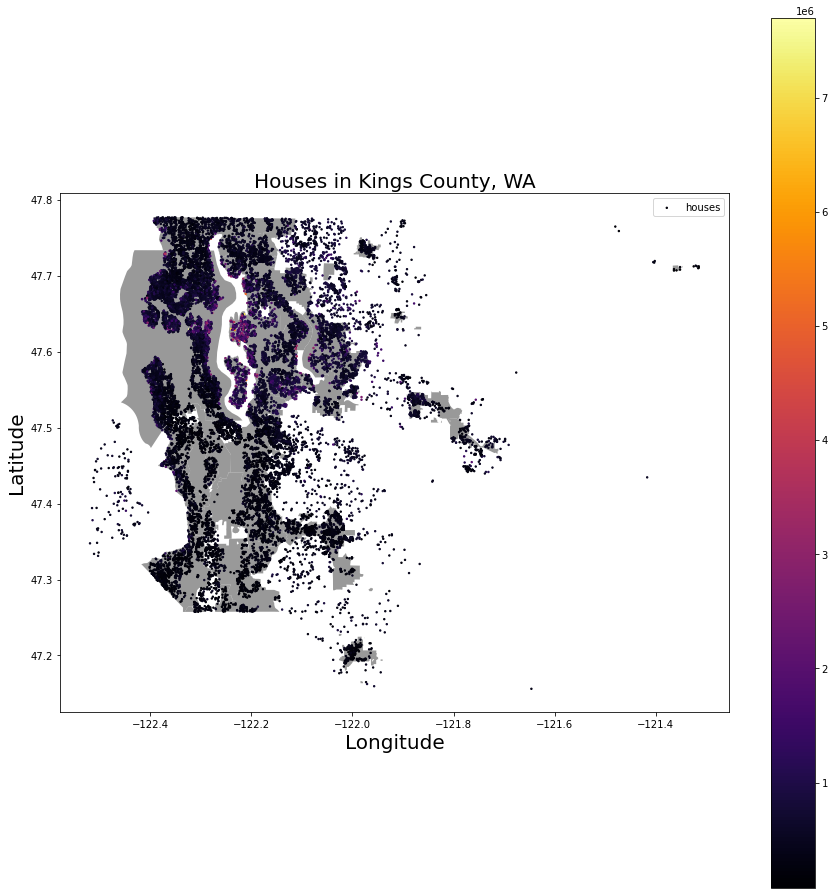

In [11]:
# plotting the data on the map using matplotlib
fig, ax = plt.subplots(figsize = (15,16))
gdf.plot(ax=ax, alpha = 0.8, color = 'Grey')
geo_df.plot(ax=ax,
            column ='price',
            cmap = 'inferno',
            legend = True,
            label= 'houses' ,
            markersize = 2,
            marker = 'o',
            aspect = 1.5
           )

plt.legend(prop = {'size':10} )
ax.set_title('Houses in Kings County, WA', fontdict = {'fontsize':
                20})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
fig.savefig('./images/kingcountyMap.png');

In [12]:
# taking a look at the dictionary containing the zipcodes and their cities
zipcode_dic

{98001: 'Auburn',
 98002: 'Auburn',
 98003: 'Federal Way',
 98004: 'Bellevue',
 98005: 'Bellevue',
 98006: 'Bellevue',
 98007: 'Bellevue',
 98008: 'Bellevue',
 98009: 'Bellevue',
 98010: 'Black Diamond',
 98011: 'Bothell',
 98012: 'Bothell',
 98013: 'Burton',
 98014: 'Carnation',
 98015: 'Bellevue',
 98019: 'Duvall',
 98020: 'Edmonds',
 98021: 'Bothell',
 98022: 'Enumclaw',
 98023: 'Federal Way',
 98024: 'Fall City',
 98025: 'Hobart',
 98026: 'Edmonds',
 98027: 'Issaquah',
 98028: 'Kenmore',
 98029: 'Issaquah',
 98030: 'Kent',
 98031: 'Kent',
 98032: 'Kent',
 98033: 'Kirkland',
 98034: 'Kirkland',
 98035: 'Kent',
 98036: 'Lynnwood',
 98037: 'Lynnwood',
 98038: 'Maple Valley',
 98039: 'Medina',
 98040: 'Mercer Island',
 98041: 'Bothell',
 98042: 'Kent',
 98043: 'Mountlake Terrace',
 98045: 'North Bend',
 98046: 'Lynnwood',
 98047: 'Pacific',
 98050: 'Preston',
 98051: 'Ravensdale',
 98052: 'Redmond',
 98053: 'Redmond',
 98054: 'Redondo',
 98055: 'Renton',
 98056: 'Renton',
 98057: 'Rent

## Data Preparation

### Data Cleaning

To clean data, we first checked duplicated values, common range of some values.

In [13]:
# check how many houses have duplicate sales in 2014 and 2015.
duplicated_val = sum(df.duplicated(subset=['bedrooms', 'bathrooms', 'sqft_living', 'yr_built', 'sqft_lot']))
print("There are " + str(duplicated_val) + " duplicated houses.")

There are 267 duplicated houses.


In [14]:
# find the amount of bedrooms most common among the houses sold in 2014 and 2015
df.groupby(['bedrooms']).count()
bedrooms_2_5 = round(df[(df.bedrooms<=5) & (df.bedrooms>=2)].price.count() / len(df) * 100, 2)
print(str(bedrooms_2_5) + "% of houses which sold in 2014, 2015 are between 2 and 5 bedrooms house")

97.55% of houses which sold in 2014, 2015 are between 2 and 5 bedrooms house


In [15]:
# find the amount of bathrooms most common among the houses sold in 2014 and 2015
df.groupby(['bathrooms']).count()
bathrooms_1_4 = round(df[(df.bathrooms<=4) & (df.bathrooms>=1)].price.count() / len(df) * 100, 2)
print(str(bathrooms_1_4) + "% of houses which sold in 2014, 2015 are between 1 and 4 bathrooms house")

98.42% of houses which sold in 2014, 2015 are between 1 and 4 bathrooms house


In [16]:
# find the number of renovated houses
renovated = len(df[df.yr_renovated > 0])
print(str(renovated) + " houses are renovated")

744 houses are renovated


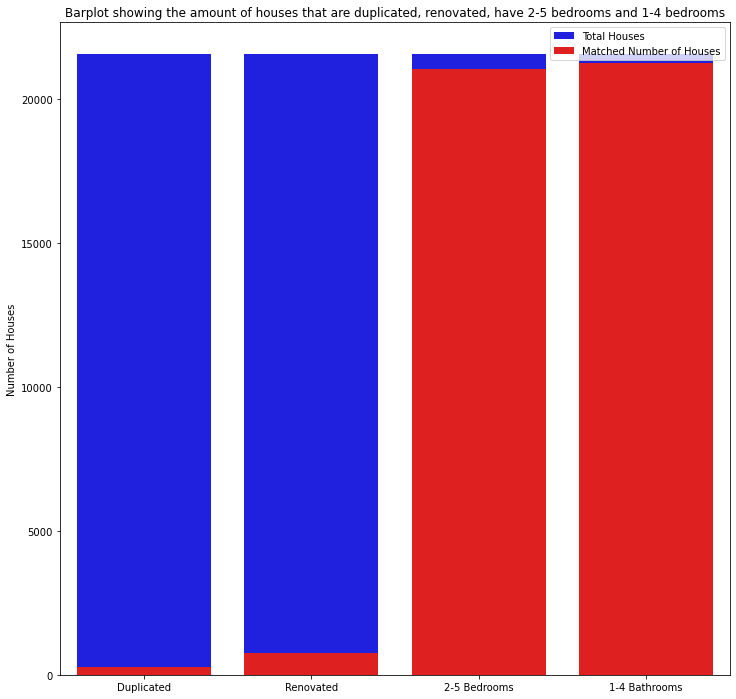

In [17]:
# compare by using barplot
Total_house = [len(df), len(df), len(df), len(df)]
result = [duplicated_val, len(df[df.yr_renovated > 0]), df[(df.bedrooms<=5) & (df.bedrooms>=2)].price.count(), df[(df.bathrooms<=4) & (df.bathrooms>=1)].price.count()]
x_ticks = ["Duplicated", "Renovated", "2-5 Bedrooms", "1-4 Bathrooms"]

fig, ax = plt.subplots(figsize=(12,12))

ax = sns.barplot(x=x_ticks, y=Total_house, color='b', label="Total Houses")
ax = sns.barplot(x=x_ticks, y=result, color='r', label="Matched Number of Houses")
ax.set(ylabel="Number of Houses", title = 'Barplot showing the amount of houses that are duplicated, renovated, have 2-5 bedrooms and 1-4 bedrooms')
ax.legend()
plt.show()
fig.savefig('./images/data_cleaning.png');

In [18]:
# drop duplicate data entries
df.drop_duplicates(subset=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built'], inplace = True)

# subset houses which have 2-5 bedrooms, 1-4 bathrooms
df = df[(df.bedrooms<=5) & (df.bedrooms>=2)]
df = df[(df.bathrooms<=4) & (df.bathrooms>=1)]

# drop nan values from yr_renovated, waterfront columns
df.dropna(subset=['yr_renovated', 'waterfront'], inplace=True)

# drop id, lat, long, sqft_living15, sqft_lot15, view, sqft_basement, sqft_above, sqft_lot, 
#which we are not going to use for our model
df.drop(['id', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'view', 'sqft_basement', 'sqft_above'], axis=1, inplace=True)

In [19]:
# make year, month columns
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [20]:
# calculated amount of year between year renovated and year sold and put in a new column
df['yr_from_renovated'] = df.year - df.yr_renovated

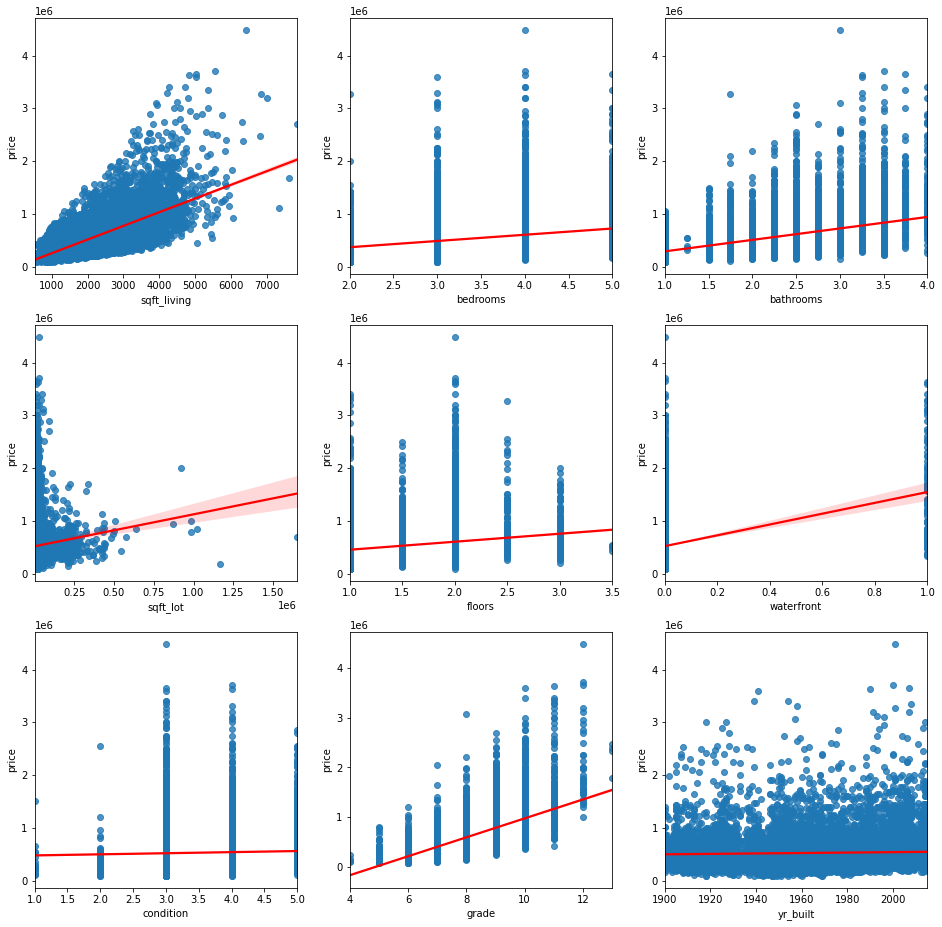

In [21]:
# create regression plots to check the relationship between price and other variables
fig, axes = plt.subplots(3, 3, figsize=(16,16))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]
ax7 = axes[2][0]
ax8 = axes[2][1]
ax9 = axes[2][2]

X = df.drop('price', axis = 1)
y = df['price']
sns.regplot(x=X['sqft_living'], y=y,line_kws={"color": "red"}, ax=ax1)
sns.regplot(x=X['bedrooms'], y=y, line_kws={"color": "red"}, ax=ax2)
sns.regplot(x=X['bathrooms'], y=y, line_kws={"color": "red"}, ax=ax3)
sns.regplot(x=X['sqft_lot'], y=y, line_kws={"color": "red"}, ax=ax4)
sns.regplot(x=X['floors'], y=y, line_kws={"color": "red"}, ax=ax5)
sns.regplot(x=X['waterfront'], y=y, line_kws={"color": "red"}, ax=ax6)
sns.regplot(x=X['condition'], y=y, line_kws={"color": "red"}, ax=ax7)
sns.regplot(x=X['grade'], y=y, line_kws={"color": "red"}, ax=ax8)
sns.regplot(x=X['yr_built'], y=y, line_kws={"color": "red"}, ax=ax9)
fig.savefig('./images/regression_plots.png');

## Feature Engineering

### Cities

We tried to use the city names instead of the zipcodes. Even though using zipcode as dummy variables can lead us to better fit model but they are so many, and we thought categorized cities can also explain the price differences between area. 

In [22]:
# mapping cities' name by using zipcode and putting them in a new 'city' column
df['city'] = df['zipcode'].map(zipcode_dic)

# getting the top 5 and last five cities by price
group_df2 = df.groupby(['city']).price.mean()
high_price_cities = ['Sammamish', 'Bellevue', 'Medina', 'Mercer Island']
low_price_cities = ['Auburn', 'Enumclaw', 'Federal Way', 'Kent', 'Maple Valley']

# make dummy variables with categorized cities (high_price_cities,low_price_cities) by using average house prices
def high_price_city(row):
    if row['city'] in high_price_cities:
        value = 1
    else:
        value = 0
    return value

def low_price_city(row):
    if row['city'] in low_price_cities:
        value = 1
    else:
        value = 0
    return value

df['high_price_cities'] = df.apply(high_price_city, axis=1)
df['low_price_cities'] = df.apply(low_price_city, axis=1)

### Years Between Date Sold and Date Renovated 

We made dummy variables for houses sold less than 20 years after renovation and those sold more than 20 years after renovation. Because some houses recently renovated will be priced higher than those not renovated, and also if it was sold more than 20 years after, then there will be no big differences compared to houses that were not renovated.

In [23]:
# make dummy variables of year between sale date and renovation date (less than 20 years and more than 20 years)
def f_0_20(row):
    if row['yr_renovated'] != 0:
        if row['year'] - row['yr_renovated'] <= 20:
            val = 1
        else:
            val = 0
    else:
        val = 0
    return val


def f_20_over(row):
    if row['yr_renovated'] != 0:
        if row['year'] - row['yr_renovated'] > 20:
            val = 1
        else:
            val = 0
    else:
        val = 0
    return val



df['renov_0_20yr'] = df.apply(f_0_20, axis=1)
df['renov_20yr_over'] = df.apply(f_20_over, axis=1)

### Waterfront

A house which located front of water is usually more expensive. The value of waterfront are 0 or 1 which means it already set as dummy variable so we just used it.

### Relationships between Price and Dummy Variables

There are significant gaps depending on average price cities, years after renovation, and whether they have a waterfront or not.

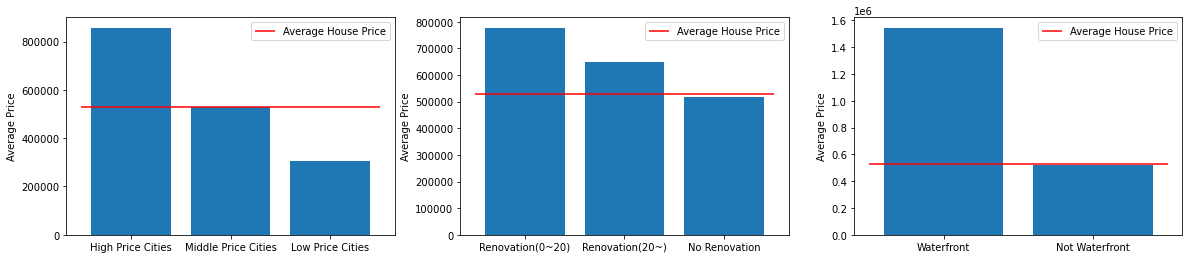

In [24]:
# Waterfront or not average house price
avg_waterfront = df[df.waterfront == 1].price.mean()
avg_not_waterfront = df[df.waterfront != 1].price.mean()
average_price = df.price.mean()

x1 = ['Waterfront', 'Not Waterfront']
y1 = [avg_waterfront, avg_not_waterfront]

# average price for houses that were renovated (less than 20 year, more than 20 years) and those that were not renovated
avg_renov_0_20yr = df[df.renov_0_20yr == 1].price.mean()
avg_renov_20yr_over = df[df.renov_20yr_over == 1].price.mean()
avg_not_renov = df[(df.renov_0_20yr != 1) & (df.renov_20yr_over != 1)].price.mean()

x2 = ['Renovation(0~20)', 'Renovation(20~)', 'No Renovation']
y2 = [avg_renov_0_20yr, avg_renov_20yr_over, avg_not_renov]

# High, middle, low average price cities' average house price
avg_high_price_cities = df[df.high_price_cities == 1].price.mean()
avg_low_price_cities = df[df.low_price_cities == 1].price.mean()
avg_middle_price_cities = df[(df.high_price_cities != 1) & (df.low_price_cities != 1)].price.mean()

x3 = ['High Price Cities', 'Middle Price Cities', 'Low Price Cities']
y3 = [avg_high_price_cities, avg_middle_price_cities, avg_low_price_cities]


# plotting the barplot
fig, axs = plt.subplots(1,3, figsize=(20,4))

axs[0].bar(x3, y3)
axs[0].hlines(y=average_price,xmin=-0.5, xmax=2.5, color='r', linestyle='-', label="Average House Price")
axs[0].set_ylabel('Average Price')
axs[0].legend()

axs[1].bar(x2, y2)
axs[1].hlines(y=average_price,xmin=-0.5, xmax=2.5, color='r', linestyle='-', label="Average House Price")
axs[1].set_ylabel('Average Price')
axs[1].legend()

axs[2].bar(x1, y1)
axs[2].hlines(y=average_price,xmin=-0.5, xmax=1.5, color='r', linestyle='-', label="Average House Price")
axs[2].set_ylabel('Average Price')
axs[2].legend()
fig.savefig('./images/Price&dummy_variables.png');

## Model Testing

We tested several models with different variables or squared variables, we removed some multicollinearity found best R-squared model. 

In [25]:
df['bedrooms_squared'] = df.bedrooms*df.bedrooms
df['bathrooms_squared'] = df.bathrooms*df.bathrooms
df['grade_squared'] = df.grade*df.grade

In [26]:
lr_model = ols(formula='price ~ bedrooms + bathrooms_squared + sqft_living + waterfront + condition + grade_squared + yr_built +renov_0_20yr + renov_20yr_over + high_price_cities + low_price_cities', data=df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3123.
Date:                Fri, 23 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:22:01   Log-Likelihood:            -2.0356e+05
No. Observations:               15071   AIC:                         4.071e+05
Df Residuals:                   15059   BIC:                         4.072e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.102e+06   1.36e+05     37.445      0.000    4.83e+06    5.37e+06
bedrooms          -3.454e+04   2327.884    -14.838      0.000   -3.91e+04      -3e+04
bathrooms_squared  1.364e+04    775.553     17.592      0.000    1.21e+04    1.52e+04
sqft_living         131.4079      3.391     38.748      0.000     124.760     138.055
waterfront         6.504e+05   1.86e+04     35.026      0.000    6.14e+05    6.87e+05
condition          2.524e+04   2472.375     10.210      0.000    2.04e+04    3.01e+04
grade_squared      7258.7638    133.503     54.372      0.000    6997.082    7520.446
yr_built          -2692.5769     68.311    -39.417      0.000   -2826.474   -2558.679
renov_0_20yr        8.24e+04   9713.576      8.483      0.000    6.34e+04    1.01e+05
renov_20yr_over   -1.142e+04   1.22e+04     -0.934      0.350   -3.54e+04    1.26e+04
high_price_cities  1.283e+05   4870.133     26.340      0.000    1.19e+05    1.38e+05
low_price_cities  -1.582e+05   3998.069    -39.561      0.000   -1.66e+05    -1.5e+05
==============================================================================
Omnibus:                     8572.319   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           200718.008
Skew:                           2.271   Prob(JB):                         0.00
Kurtosis:                      20.292   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# make predicted price column
df['predicted_price'] = (5.102e+06) - (3.454e+04)*df.bedrooms + (1.364e+04)*df.bathrooms_squared + (131.4079)*df.sqft_living + (6.504e+05)*df.waterfront + (2.524e+04)*df.condition + (7258.7638)*df.grade_squared - (2692.5769)*df.yr_built + (8.24e+04)*df.renov_0_20yr - (1.142e+04)*df.renov_20yr_over + (1.283e+05)*df.high_price_cities - (1.582e+05)*df.low_price_cities

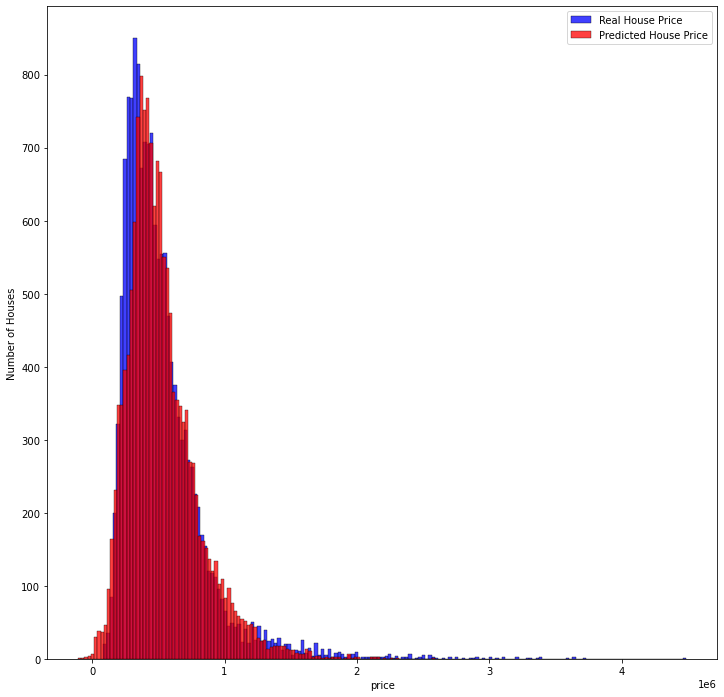

In [28]:
# compare real price and predicted price by using histplot
Total_house = [len(df), len(df), len(df), len(df)]
result = [duplicated_val, len(df[df.yr_renovated > 0]), df[(df.bedrooms<=5) & (df.bedrooms>=2)].price.count(), df[(df.bathrooms<=4) & (df.bathrooms>=1)].price.count()]
x_ticks = ["Duplicated", "Renovated", "2-5 Bedrooms", "1-4 Bathrooms"]

fig, ax = plt.subplots(figsize=(12,12))

ax = sns.histplot(df.price, color='b', label="Real House Price")
ax = sns.histplot(df.predicted_price, color='r', label="Predicted House Price")
ax.set(ylabel="Number of Houses")
ax.legend()
plt.show()
fig.savefig('./images/Real_predicted_price.png');

In [29]:
# train test
price = df.price
bedrooms = df.bedrooms
bathrooms_squared = df.bathrooms_squared
sqft_living = df.sqft_living
waterfront = df.waterfront
condition = df.condition
grade_squared = df.grade_squared
yr_built = df.yr_built
renov_0_20yr = df.renov_0_20yr
renov_20yr_over = df.renov_20yr_over
high_price_cities = df.high_price_cities
low_price_cities = df.low_price_cities

data = pd.concat([price, bedrooms, bathrooms_squared, sqft_living, waterfront, condition, grade_squared, yr_built, renov_0_20yr, renov_20yr_over, high_price_cities, low_price_cities], axis=1)
y = data[['price']]
X = data.drop(['price'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)


train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

train_rmse = np.sqrt(train_mse)
print('Train RMSE: ',train_rmse)

test_rmse = np.sqrt(test_mse)
print('Test RMSE: ',test_rmse)

Train RMSE:  174598.4615113213
Test RMSE:  189719.023194724
